# Project 5 - Vehicle Detection and Tracking

## Introduction

In this project, we apply Computer Vision to the task of vehicle detection and tracking on a video feed.

In [1]:
import os
import math
import cv2
import glob
import zipfile
import scipy
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from moviepy.editor import VideoFileClip
from IPython.display import display, HTML
from urllib.request import urlretrieve
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

%matplotlib inline

## Tools and helper functions

In [2]:
def get_output_dir():
    output_dir = './output_images'
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    return output_dir

def get_classifier_path():
    return './classifier.pickle'

def save_plt_img(fig_handle, fname):
    plt.figure(fig_handle.number)
    plt.savefig(os.path.join(get_output_dir(), fname + '.jpg'))
    
def save_cv_img(img, fname):
    scipy.misc.imsave(os.path.join(get_output_dir(), fname + '.jpg'), img)
    
def read_img(fname):
    return scipy.misc.imread(fname)

def display_img(img, title):
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    
    plt.axis('off')
    plt.title(title)

## Data download and unpacking

In [3]:
vehicles_file = 'vehicles.zip'
non_vehicles_file = 'non-vehicles.zip'
download_url_base = 'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/'

In [4]:
def download(url):
    # Get file name
    file = url.rsplit('/', 1)[-1]
    
    # Download
    print('Downloading ' + file + '...')
    if not os.path.isfile(file):
        urlretrieve(url, file)
        print('Download Finished')
    else:
        print('File already in the filesystem!')
        
download(url = download_url_base + vehicles_file)
download(url = download_url_base + non_vehicles_file)

File already in the filesystem!
File already in the filesystem!


In [5]:
def unzip(file):
    if not os.path.isdir(os.path.splitext(file)[0]):        
        print('Unzipping ' + file + '...')
        with zipfile.ZipFile(file,"r") as zip_ref:
            zip_ref.extractall()
    else:
        print('File ' + file + ' already unpacked!')

unzip(vehicles_file)
unzip(non_vehicles_file)

File vehicles.zip already unpacked!
File non-vehicles.zip already unpacked!


## Data loading

In [6]:
def get_img_shape():
    return (64, 64, 3)

def get_vehicle_label():
    return 1

def get_non_vehicle_label():
    return 0

def load_dataset(class_base_folder, class_id):
    # Get filenames recursively
    f_names = glob.glob(class_base_folder + '/**/*.png')
    
    # Declare output arrays
    n_img = len(f_names)
    X = np.zeros((n_img,) + get_img_shape(), dtype = np.uint8)
    y = np.zeros((n_img,), dtype = int)
    
    # Read images and store them in memory
    for i in range(n_img):
        # Note: the input image is PNG, therefore a float32 array between 0.0 and 1.0
        X[i] = read_img(f_names[i])
        y[i] = class_id
        
    return X, y

print('Loading datasets...')
Img_v, y_v = load_dataset('vehicles', get_vehicle_label())
Img_nv, y_nv = load_dataset('non-vehicles', get_non_vehicle_label())
print('Done...')

Loading datasets...
Done...


In [7]:
print('Vehicle training data: ', Img_v.shape, y_v.shape)
print('Non-vehicle training data: ', Img_nv.shape, y_nv.shape)

Img = np.concatenate((Img_v, Img_nv))
y = np.concatenate((y_v, y_nv))

print('Combined dataset: ', Img.shape, y.shape)
print(np.amin(Img), np.amax(Img))

Vehicle training data:  (8792, 64, 64, 3) (8792,)
Non-vehicle training data:  (8968, 64, 64, 3) (8968,)
Combined dataset:  (17760, 64, 64, 3) (17760,)
0 255


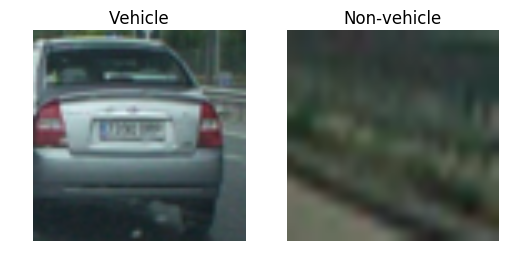

In [8]:
h = plt.figure()
plt.subplot(1,2,1);
display_img(Img_v[0], 'Vehicle')
plt.subplot(1,2,2);
display_img(Img_nv[0], 'Non-vehicle')

save_plt_img(fig_handle=h, fname='vehicle_non_vehicle')

## Data augmentation

In [9]:
def augment_data(X, y):
    raise NotImplemented

## Data preprocessing

In [10]:
def rgb_to_ycrcb(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def preprocess_img(Img):
    Img_out = np.copy(Img)
    
    if len(Img.shape) == 3:
        Img_out = rgb_to_ycrcb(Img)
    else:
        for i in range(Img.shape[0]):
            Img_out[i] = cv2.cvtColor(Img[i], cv2.COLOR_RGB2YCrCb)
    
    return Img_out

Img_v_pp = preprocess_img(Img_v)
Img_nv_pp = preprocess_img(Img_nv)
Img_pp = preprocess_img(Img)

## HOG feature extraction

In [11]:
def get_hog_features(img, debug = False):
    # Setup HOG parameters
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9

    img_shape = img.shape
    n_channels = img_shape[2]
    
    features = []
    hog_image = np.zeros_like(img)
    
    for i in range(n_channels):
        if debug:
            features_i, hog_image[:, :, i] = hog(img[:, :, i], orientations=orient, 
                                                 pixels_per_cell=(pix_per_cell, pix_per_cell),
                                                 cells_per_block=(cell_per_block, cell_per_block),
                                                 visualise=debug, feature_vector=False)
        else:
            features_i = hog(img[:, :, i], orientations=orient, 
                             pixels_per_cell=(pix_per_cell, pix_per_cell),
                             cells_per_block=(cell_per_block, cell_per_block),
                             visualise=debug, feature_vector=False)
       
        features.append(features_i)

    features = np.stack(features, axis=-1)
        
    if debug:        
        return features, hog_image
    else:
        return features

def get_hog_features_batch(Img):
    features = []
    for i in range(Img.shape[0]):
        features.append(get_hog_features(Img[i], debug=False).ravel())
    return np.array(features)

(7, 7, 2, 2, 9, 3) float64 (64, 64, 3) uint8


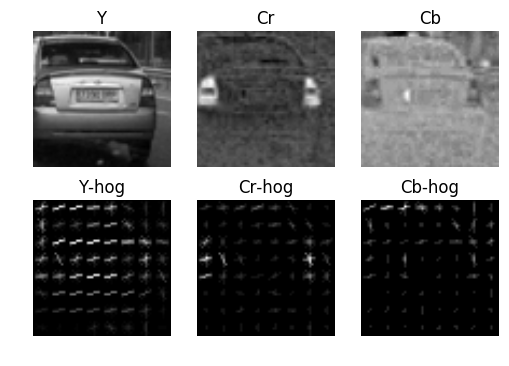

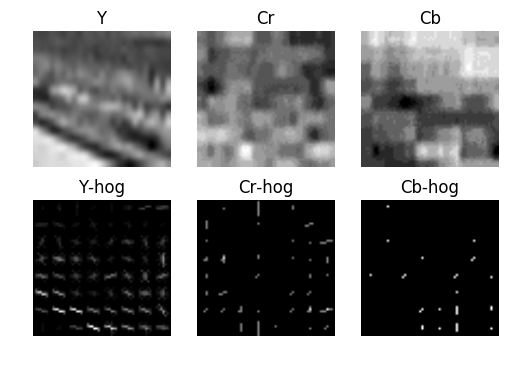

In [12]:
def test_hog_features():
    img_v = Img_v_pp[0]
    img_nv = Img_nv_pp[0]

    features_v, hog_image_v = get_hog_features(img_v, debug=True)
    features_nv, hog_image_nv = get_hog_features(img_nv, debug=True)

    print(features_v.shape, features_v.dtype, hog_image_v.shape, hog_image_v.dtype)

    h = plt.figure()
    img_labels = ['Y', 'Cr', 'Cb']

    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 0 + 1);
        display_img(img_v[:, :, idx], img_labels[idx])

    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 1 + 1);
        display_img(hog_image_v[:, :, idx], img_labels[idx] + '-hog')
        
    save_plt_img(fig_handle=h, fname='hog_img_vehicle')
        
    h = plt.figure()
    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 0 + 1);
        display_img(img_nv[:, :, idx], img_labels[idx])
        
    for idx in range(3):
        plt.subplot(2,3, idx + 3 * 1 + 1);
        display_img(hog_image_nv[:, :, idx], img_labels[idx] + '-hog')
        
    save_plt_img(fig_handle=h, fname='hog_img_non_vehicle')        

test_hog_features()

In [13]:
features_file = 'features.pickle'

if not os.path.exists(features_file):
    print('Computing HOG features for the entire dataset...')
    X = get_hog_features_batch(Img_pp)
    print('Saving features into ' + features_file + '...')
    pickle.dump(X, open(features_file, 'wb'))
    print('Done')
else:
    print('Loading features from ' + features_file + '...')
    X = pickle.load(open(features_file, 'rb'))
    print('Done')
    
X = X.astype(np.float64)
print(X.shape)

Loading features from features.pickle...
Done
(17760, 5292)


## Dataset preparation

In [14]:
def normalize_features(X):
    X_scaler = StandardScaler().fit(X)    
    return X_scaler.transform(X)    

print('Normalizing features...')
X_norm = normalize_features(X)
print('Done')

Normalizing features...
Done


In [15]:
def split_validation(X, y):
    val_ratio = 0.2
    random_state = 918273645
    return train_test_split(X, y, test_size = val_ratio, random_state = random_state)

print('Splitting into train/validation set...')
X_train, X_val, y_train, y_val = split_validation(X_norm, y)

print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)

Splitting into train/validation set...
X_train:  (14208, 5292)
X_val:  (3552, 5292)


## Classifier Design

In [16]:
def define_classifier():
    kernel='rbf'
    svc = SVC(kernel=kernel)
    return svc

## Training

In [17]:
def train_classifier(classifier, X_train, y_train):
    classifier.fit(X_train, y_train)

In [18]:
def save_classifier(classifier, path):
    joblib.dump(classifier, path)

In [19]:
def load_classifier(path):
    return joblib.load(path)

In [20]:
if not os.path.exists(get_classifier_path()):
    # Create classifier
    classifier = define_classifier()
    
    # Train it
    print('Training classifier...')
    t = time.time()
    train_classifier(classifier, X_train, y_train)
    print('Done in %.3f s' % (time.time() - t))
    
    # Save to disk for the future
    save_classifier(classifier, get_classifier_path())
else:
    classifier = load_classifier(get_classifier_path())

## Cross-validation

In [21]:
def compute_validation_accuracy(classifier, X_val, y_val):
    return classifier.score(X_val, y_val)
    
print('Validation accuracy: %.3f%%' % (100. * compute_validation_accuracy(classifier, X_val, y_val)))

Validation accuracy: 99.352%


## Test on single image

In [22]:
def classify_img(img):
    # Preprocess
    img = preprocess_img(img)
    
    # Extract and normalize features
    x = get_hog_features(img).ravel()
    x = normalize_features(x)
    
    # Predict
    return classifier.predict(x)

Time for classifying single 64x64 image: 0.018 s


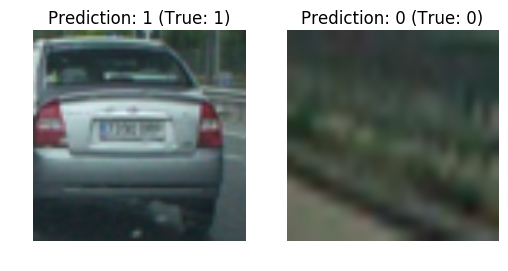

In [23]:
img_v_test = Img_v[0]
t = time.time()
y_v_predicted = classify_img(img_v_test)
print('Time for classifying single 64x64 image: %.3f s' % (time.time() - t))

img_nv_test = Img_nv[0]
y_nv_predicted = classify_img(img_nv_test)

h = plt.figure();
plt.subplot(1,2,1);
display_img(img_v_test, 'Prediction: %d (True: %d)' % (y_v_predicted, get_vehicle_label()))
plt.subplot(1,2,2);
display_img(img_nv_test, 'Prediction: %d (True: %d)' % (y_nv_predicted, get_non_vehicle_label()))

save_plt_img(h, 'svm_test')

---
## Sliding Window Search

In [24]:
class SearchWindow:
    
    def __init__(self, x0, y0, size_x, size_y):
        self.x0 = x0
        self.y0 = y0
        self.size_x = size_x
        self.size_y = size_y  
        
    def get_img_contents(self, img):
        return img[self.y0 : self.y0 + self.size_y, 
                   self.x0 : self.x0 + self.size_x]
    
    def get_hog_features(self, img_hog_features, pixels_per_cell):
        '''
            Extracts HOG features given as input the HOG features
            from the complete image. This way we only need to compute
            them once.
        '''
        # Get block indices for this bounding box
        block_idx_x_start = self.x0 // pixels_per_cell 
        block_idx_y_start = self.y0 // pixels_per_cell
        
        block_idx_x_end = block_idx_x_start + self.size_x // pixels_per_cell - 1
        block_idx_y_end = block_idx_y_start + self.size_y // pixels_per_cell - 1
        
        # Extract features
        return img_hog_features[block_idx_y_start : block_idx_y_end,
                                block_idx_x_start : block_idx_x_end, :, :, :, :]
    
    def draw_on_img(self, img, color=(0,0,255), thickness=2):
        p1 = (self.x0,               self.y0)
        p2 = (self.x0,               self.y0 + self.size_y)
        p3 = (self.x0 + self.size_x, self.y0 + self.size_y)
        p4 = (self.x0 + self.size_x, self.y0)
        
        p = (p1, p2, p3, p4)
        
        for i in range(4):
            cv2.line(img, p[i], p[(i+1) % 4], color=color, thickness=thickness)
            
    def contains_vehicle(self, img_hog_features, pixels_per_cell):
        # Get HOG features for this window
        features = self.get_hog_features(img_hog_features, pixels_per_cell).ravel()
        
        # Classify image
        features = normalize_features(features)
        y = classifier.predict(features)
        
        # Return true if the prediction is a vehicle        
        return True if y == get_vehicle_label() else False        

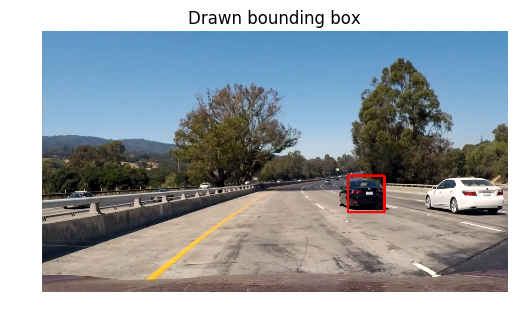

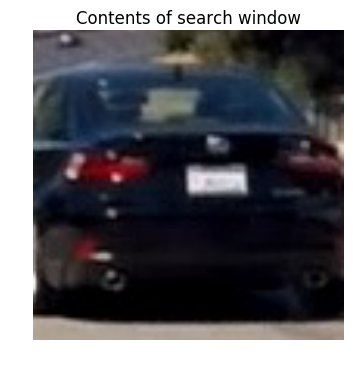

In [25]:
def test_get_img_contents():
    img = read_img('./test_images/test1.jpg')
    window = SearchWindow(840,400,100,100)
    display_img(window.get_img_contents(img), 'Contents of search window')
    
def test_draw_on_img():
    img = read_img('./test_images/test1.jpg')
    window = SearchWindow(840,400,100,100)    
    window.draw_on_img(img, color = (255,0,0), thickness=5)
    display_img(img, 'Drawn bounding box')

plt.figure();
test_draw_on_img()    
plt.figure();
test_get_img_contents()

(89, 159, 2, 2, 9, 3)
(7, 7, 2, 2, 9, 3)
(7, 7, 2, 2, 9, 3)
Image difference:  0
Test passed!


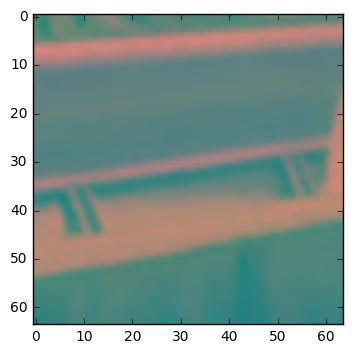

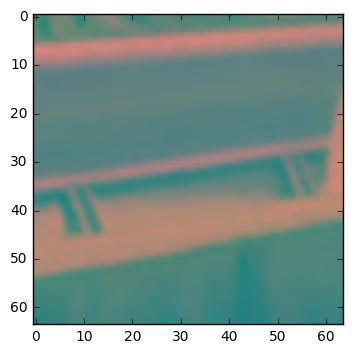

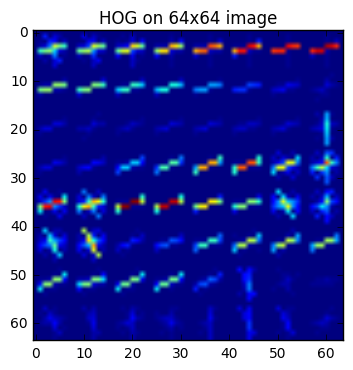

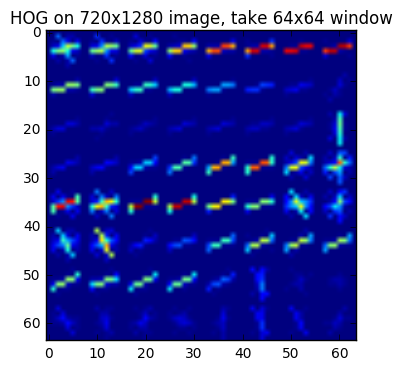

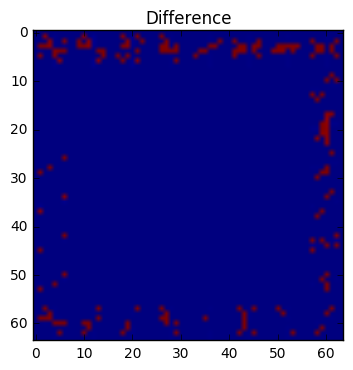

In [26]:
def test_hog_features():
    # Read image
    img = preprocess_img(read_img('./test_images/test1.jpg'))
    img2 = np.copy(img)
    
    # Define window
    x0 = 192
    y0 = 448
    pixels_per_cell = 8
    window = SearchWindow(x0, y0, 64, 64)
    
    # Get sub-image and compute HOG features
    sub_img = window.get_img_contents(img)
    features_sub_image, debug1 = get_hog_features(sub_img, debug=True)
    
    # Compute HOG features in global image, and get features from it
    hog_features_whole_image, debug2 = get_hog_features(img2, debug=True)
    print(hog_features_whole_image.shape)
    features_sub_hog = window.get_hog_features(hog_features_whole_image, pixels_per_cell=pixels_per_cell)
    
    # Verify that the vector is exactly the same
    print(features_sub_image.shape)
    print(features_sub_hog.shape)
    
    plt.figure()
    plt.imshow(sub_img)
    plt.figure()
    plt.imshow(img2[y0:y0+64,x0:x0+64, :])
    print('Image difference: ', np.sum(sub_img - img2[y0:y0+64,x0:x0+64]))
    
    plt.figure()
    plt.title('HOG on 64x64 image')    
    plt.imshow(debug1[:, :, 0])
    plt.figure()
    plt.title('HOG on 720x1280 image, take 64x64 window')
    plt.imshow(debug2[y0:y0+64,x0:x0+64, 0])
        
    plt.figure()
    plt.imshow(debug1[:,:,0] - debug2[y0:y0+64,x0:x0+64, 0])
    plt.title('Difference')
        
    assert(features_sub_image.shape == features_sub_hog.shape)
   
    for i in range(1, pixels_per_cell - 2):
        assert(np.sum(abs(features_sub_image[i, 1]                 - features_sub_hog[i, 1])) == 0.)
        assert(np.sum(abs(features_sub_image[i, pixels_per_cell-3] - features_sub_hog[i, pixels_per_cell-3])) == 0.)
        assert(np.sum(abs(features_sub_image[1, i]                 - features_sub_hog[1, i])) == 0.)
        assert(np.sum(abs(features_sub_image[pixels_per_cell-3, i] - features_sub_hog[ pixels_per_cell-3, i])) == 0.)
    
    print('Test passed!')
    
test_hog_features()

In [27]:
def get_search_windows(img_shape):
    # Parameters
    x_start = 0
    y_start = img_shape[0] // 2
    x_end = img_shape[1]
    y_end = img_shape[0]
    
    size_start = 64
    size_step = 32
    size_end = size_start + size_step

    overlap = 0.8    

    # Search windows
    bboxes_out = []
    for size in range(size_start, size_end, size_step):    
        step = int((1.0 - overlap) * size) 

        for y in range(y_start, y_end - size, step):
            for x in range(x_start, x_end - size, step):                
                box = SearchWindow(x, y, size, size)
                bboxes_out.append(box)
        
    return bboxes_out

In [28]:
def draw_search_windows(img, windows, color, thickness):
    for w in windows:
        w.draw_on_img(img, color, thickness)

Obtained 2550 boxes


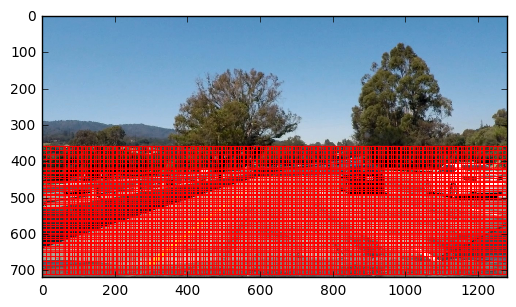

In [29]:
def test_bboxes():
    img = read_img('./test_images/test1.jpg')
    bboxes = get_search_windows(img.shape)
    print('Obtained %d boxes' % len(bboxes))
    draw_search_windows(img, bboxes, color=(255,0,0), thickness=2)
    plt.imshow(img)
    save_cv_img(fname= 'search_boxes', img=img)
    
test_bboxes()

In [30]:
def detect_vehicles(img_hog_features, pixels_per_cell, search_windows):
    vehicle_windows = []
    
    for w in search_windows:
        if w.contains_vehicle(img_hog_features, pixels_per_cell):
            vehicle_windows.append(w)
    
    return vehicle_windows

## Heat map

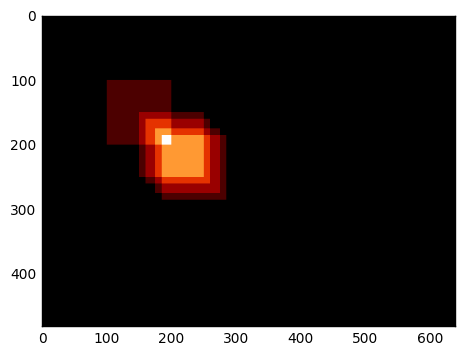

In [31]:
def update_heat_map(heatmap, boxes):
    for box in boxes:
        # Add += 1 for all pixels inside each bbox
        x_start = box.x0
        x_end = x_start + box.size_x
        y_start = box.y0
        y_end = y_start + box.size_y
        
        heatmap[y_start:y_end, x_start:x_end] += 1

    return heatmap

def test_update_heat_map():
    # Create heatmap
    heatmap = np.zeros((480, 640), dtype = np.uint32)
    
    # Create boxes
    boxes = []
    boxes.append(SearchWindow(100,100,100,100))
    boxes.append(SearchWindow(150, 150, 100,100))
    boxes.append(SearchWindow(160, 160, 100,100))
    boxes.append(SearchWindow(175, 175, 100,100))
    boxes.append(SearchWindow(185, 185, 100,100))
        
    # Update
    heatmap = update_heat_map(heatmap, boxes)
    
    # Display
    h = plt.figure()
    plt.imshow(heatmap, cmap='gist_heat')
    
test_update_heat_map()

## Single Image pipeline

In [32]:
class SingleImagePipeline:
    def __init__(self, debug = False):
        self.debug = debug
        self.pixels_per_cell = 8
        
    def run(self, img):
        # Preprocess
        img_pp = preprocess_img(img)
        
        # Extract HOG features for the whole image
        img_hog_features = get_hog_features(img_pp)
        
        # Get search windows
        search_windows = get_search_windows(img.shape)
        
        # Get positive detection boxes
        vehicle_windows = detect_vehicles(img_hog_features, self.pixels_per_cell, search_windows)
        
        # Draw final boxes on image
        draw_search_windows(img, vehicle_windows, color=(0,0, 255), thickness=5)  
        
        # Output final image
        return img

## Test on images

Time for complete image: 31.080 s
Time for complete image: 30.925 s
Time for complete image: 30.010 s
Time for complete image: 30.465 s
Time for complete image: 30.634 s
Time for complete image: 30.578 s


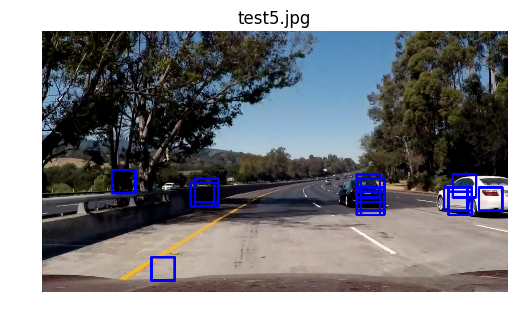

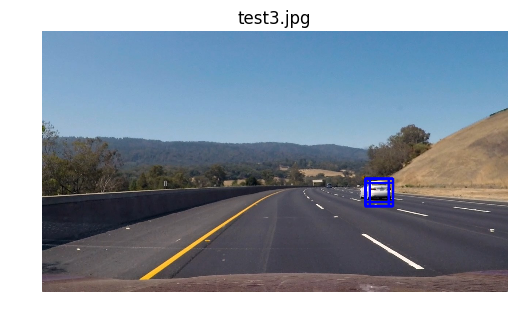

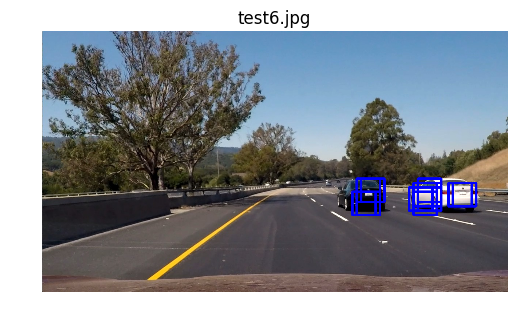

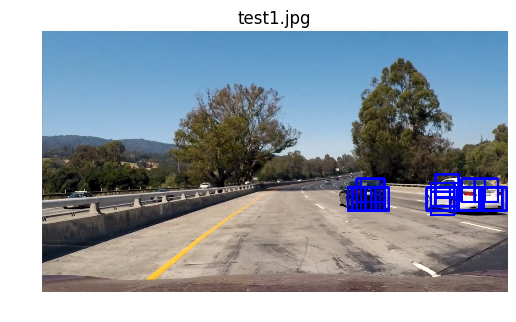

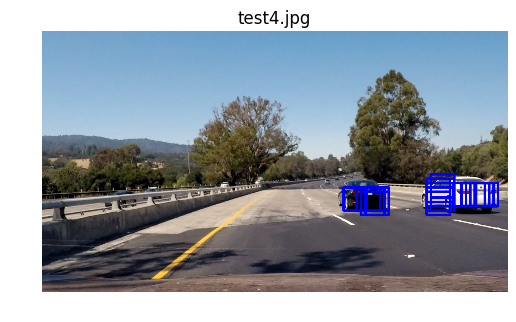

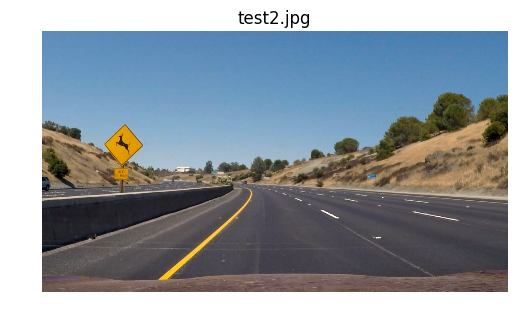

In [33]:
test_images = glob.glob('./test_images/*.jpg')

for img_path in test_images:
    _,img_name = os.path.split(img_path)
    
    # Read image
    img = read_img(img_path)
    
    # Create a new LaneFindingPipeline
    pipeline = SingleImagePipeline(debug = True)
    
    # Run it on the image
    t = time.time()
    img_out = pipeline.run(img)
    print('Time for complete image: %.3f s' % (time.time() - t))
    
    # Display
    plt.figure();
    display_img(img_out, img_name);
    
    # Save to disk
    save_cv_img(img_out, os.path.splitext(img_name)[0] + '_processed')

## Video pipeline

## Test on video